# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
display(HTML("""
<style>
.container { 
   width:90% !important; 
   position: relative; 
   right: 25px; 
}
</style>
"""))

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


В датасете 7591 фотография

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


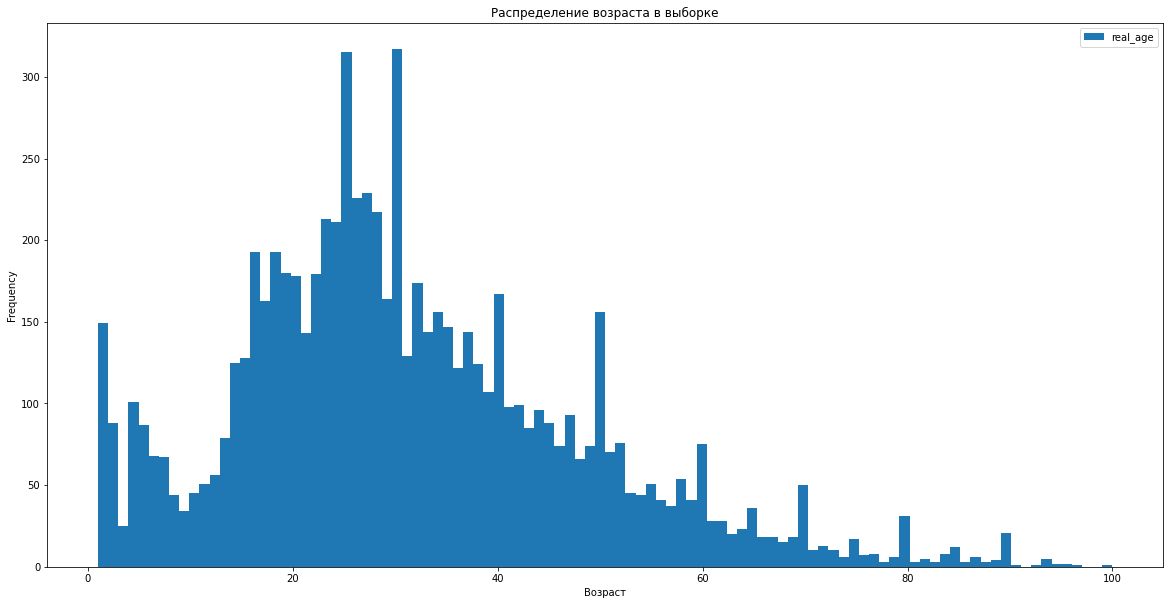

In [4]:
fig, ax = plt.subplots()
ax.set_title('Распределение возраста в выборке')
ax.set_xlabel('Возраст')
df.plot(kind='hist', bins=100, figsize=(20,10), ax=ax)
plt.show()

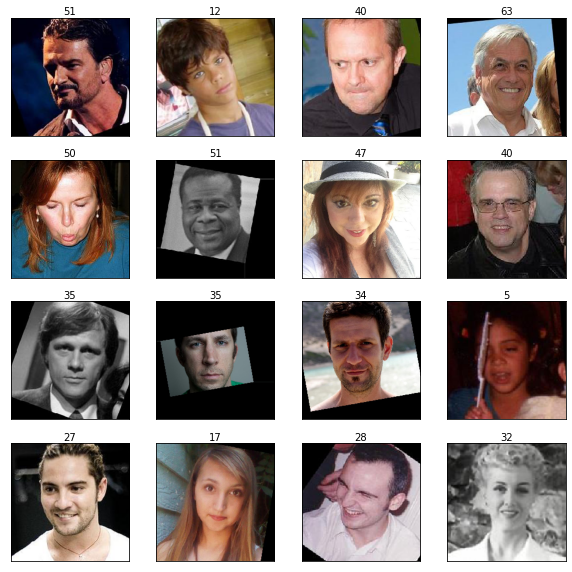

In [6]:
features, target = next(gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.text(0.5, 1.05, target[i], horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

### Вывод по исследовательскому анализу
* Как мы можем видеть - некоторые фотографии повернуты или обрезаны (видны черные края), есть как цветные так и черно-белые фотографии, также фотографии имеют разное качество. Возможно все это может как-то повлиять на обучение и последующие предсказания
* Возраст распределен более менее нормально. За исключением аномального пика около 0 лет (много фото младенцов от их родителей?) и малым кол-вом фотографий старшего поколения (старшее поколение меньше фотографируется по различным причинам).

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
 
def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                        rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory= path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
 
def create_model(input_shape):    
    backbone = ResNet50(input_shape=input_shape,weights='imagenet', include_top=False)
    model = Sequential()   
    model.add(backbone)
    model.add(GlobalAveragePooling2D())  
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)    
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
             validation_data=test_data,
             batch_size=batch_size, epochs=epochs,
             steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps,
             verbose=2)
 
    return model
```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-11-20 14:00:50.574711: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-20 14:00:52.188017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 69s - loss: 193.1260 - mae: 10.2396 - val_loss: 918.9217 - val_mae: 25.4903
Epoch 2/10
356/356 - 39s - loss: 66.9996 - mae: 6.2617 - val_loss: 116.1703 - val_mae: 8.1079
Epoch 3/10
356/356 - 39s - loss: 37.4409 - mae: 4.7012 - val_loss: 87.9778 - val_mae: 6.9861
Epoch 4/10
356/356 - 38s - loss: 24.8812 - mae: 3.8453 - val_loss: 80.9173 - val_mae: 7.0251
Epoch 5/10
356/356 - 38s - loss: 19.2888 - mae: 3.3763 - val_loss: 71.4249 - val_mae: 6.4043
Epoch 6/10
356/356 - 38s - loss: 14.8528 - mae: 2.9168 - val_loss: 74.9787 - val_mae: 6.5665
Epoch 7/10
356/356 - 38s - loss: 12.6017 - mae: 2.6787 - val_loss: 66.9038 - val_mae: 6.2138
Epoch 8/10
356/356 - 38s - loss: 11.3143 - mae: 2.5538 - val_loss: 71.2569 - val_mae: 6.5026
Epoch 9/10
356/356 - 38s - loss: 10.1585 - mae: 2.4015 - val_loss: 83.1308 - val_mae: 6.8299
Epoch 10/10
356/356 - 38s - loss: 9.3863 - mae: 2.3277 - val_loss: 68.8532 - val_mae: 6.2494
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 68.8532 - mae: 6.2494
Test MAE: 6.2494

```

## Анализ обученной модели
Мы получили результат MAE = 6.2494 на валидационной выборке, что удовлетворяет поставленному условию. На тренировочной выборке модель стабильно показывает понижение потерь, как и значение MAE. При этом при проверке на валидационной выборке потери сначала уменьшаются в течении 5 эпох, а затем идет непоследовательное повышение/понижение потерь. Возможно это говорит о том, что модель переобучена, но четкой уверенности у меня в этом нет. Тем не менее, даже если переобучение имело место быть, то это не повлияло на достижение желаемого результата.
Для улучшения результата можно сделать несколько вещей:
* попробовать поменять значение оптимизатора - возможно с большим значением модель будет меньше переобучаться (если такое имело место быть)
* в целом у ResNet есть такой недостаток, что на малом кол-ве данных эта сеть слишком подгоняет результаты на обучающих данных - возможно следует добавить фоток людей с возрастами в исходные данные
* можно упростить модель, как и в предыдущем пункте - ResNet при слишком сложной модели (на мой взгляд моя такой не является, но я могу ошибаться) слишком подгоняет результаты на обучающих данных

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы